#  <center><u>Project Benson</u></center>
### <center>Recommendations for placement of street teams using MTA data</center>

## Problem Statement
WomenTechWomenYes (WTWY) has an annual gala at the beginning of the summer each year. They want to place 
street teams at entrances to subway stations to increase awareness about the event. We have been contacted to 
optimize placement of the street teams to maximise turout at the event. We decided to use MTA data to find stations 
with most traffic and to uncover other trends. 

In [423]:
#######################
# standard code block #
#######################

%pylab inline
%matplotlib inline 
# see https://ipython.readthedocs.io/en/stable/interactive/magics.html

%config InlineBackend.figure_format = 'svg'

Populating the interactive namespace from numpy and matplotlib


## Setting up Panda's dafault parameters

In [424]:
# imports a library 'pandas', names it as 'pd'
# this is a common convention
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [425]:
# if you run into trouble, it's often helpful to know which version you're on
print("Pandas version:", pd.__version__)
print("Numpy version:", np.__version__)

Pandas version: 0.24.2
Numpy version: 1.16.4


In [426]:
# various options in pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 25)
pd.set_option('display.precision', 3)

## Downloading MTA data

Downloading MTA data from June 30, 2018 till August 3, 3018. Duration is 35 days or 5 weeks.

In [427]:
# download the data and name the columns
cols = [
    'ca', 'unit', 'scp', 'station', 'linename',
    'division', 'date', 'time', 'desc', 'entries',
    'exits'
]

df1 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_180707.txt', names=cols, skiprows=1)
df2 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_180714.txt', names=cols, skiprows=1)
df3 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_180721.txt', names=cols, skiprows=1)
df4 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_180728.txt', names=cols, skiprows=1)
df5 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_180804.txt', names=cols, skiprows=1)

df = pd.concat([df1, df2, df3, df4, df5])

## Data Exploration

In [428]:
# Creating a column to store minimum entry count for a turnstile per day. Initializing to value in entries column.
df['entries_min'] = df['entries']

# Creating a column to store maximum entry count for a turnstile per day. Initializing to value in entries column.
df['entries_max'] = df['entries']

# Creating a column to store minimum exit count for a turnstile per day. Initializing to value in exits column.
df['exits_min'] = df['exits']

# Creating a column to store maximum exit count for a turnstile per day. Initializing to value in exits column.
df['exits_max'] = df['exits']

In [429]:
# Grouping table by ca, unit, scp, station and date to get unique turnstile events. Calculating minimum and maximum 
# entry and exit counts for each turnstile per day.
df_turnstile_traffic_per_day = df.groupby(['ca','unit','scp','station','date'])\
.agg({'entries_min':'min','entries_max':'max'\
     , 'exits_min':'min','exits_max':'max'})

In [430]:
# Expand DataFrame creating by grouping
df_turnstile_traffic_per_day = df_turnstile_traffic_per_day.reset_index()

### We have 163869 entry points. Each point corresponds to data received from a single turnstile for one day

In [431]:
df_turnstile_traffic_per_day.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 163869 entries, 0 to 163868
Data columns (total 9 columns):
ca             163869 non-null object
unit           163869 non-null object
scp            163869 non-null object
station        163869 non-null object
date           163869 non-null object
entries_min    163869 non-null int64
entries_max    163869 non-null int64
exits_min      163869 non-null int64
exits_max      163869 non-null int64
dtypes: int64(4), object(5)
memory usage: 11.3+ MB


In [432]:
# Calculating total entry traffic for each turnstile for each day. 4 hrs of data between 8pm and 4am of next day will
# be missed for each day
df_turnstile_traffic_per_day['traffic_entry'] = df_turnstile_traffic_per_day['entries_max'] - \
df_turnstile_traffic_per_day['entries_min']

In [433]:
# Calculating total exit traffic for each turnstile for each day. 4 hrs of data between 8pm and 4am of next day will
# be missed for each day
df_turnstile_traffic_per_day['traffic_exit'] = df_turnstile_traffic_per_day['exits_max'] - \
df_turnstile_traffic_per_day['exits_min']

In [434]:
# Calculating total traffic for each turnstile for each day. 4 hrs of data between 8pm and 4am of next day will
# be missed for each day
df_turnstile_traffic_per_day['total_traffic'] = df_turnstile_traffic_per_day['traffic_entry'] + \
df_turnstile_traffic_per_day['traffic_exit']

### Let's explore the traffic data we have!

Assuming maximum possible turnstile events for a whole day would be 50,000 (assuming a little more than a 
single event every 2 seconds), 66 (0.47% of total points) data points have traffic value higher than 50,000. 
This is most likely because the turnstill is broken

In [435]:
# Finding data points where traffic per day for a turnstile exceeds 50000
df_turnstile_traffic_per_day.loc[df_turnstile_traffic_per_day.total_traffic > 50000]

,ca,unit,scp,station,date,entries_min,entries_max,exits_min,exits_max,traffic_entry,traffic_exit,total_traffic
9037,A060,R001,00-00-06,WHITEHALL S-FRY,07/15/2018,41,540799,91,772422,540758,772331,1313089
10838,A084,R125,01-03-00,BROAD ST,08/01/2018,7,364194,0,22734,364187,22734,386921
13364,B021,R228,00-03-00,AVENUE J,07/03/2018,3584210,16809292,2528773,16996250,13225082,14467477,27692559
14771,B026,R230,00-00-00,NECK RD,07/10/2018,29,98882,16,108757,98853,108741,207594
26303,H015,R250,01-00-01,GRAND ST,07/12/2018,319,2944492,63,760378,2944173,760315,3704488
29024,H041,R152,00-06-00,CANARSIE-ROCKAW,07/12/2018,52,1071940,0,42723,1071888,42723,1114611
30713,J017,R432,00-00-00,CHAUNCEY ST,07/18/2018,97,338736,80,106583,338639,106503,445142
32863,JFK03,R536,00-00-03,JFK JAMAICA CT1,08/02/2018,42,547113,29,387767,547071,387738,934809
32955,JFK03,R536,00-03-00,JFK JAMAICA CT1,07/21/2018,20,162300,65,170424,162280,170359,332639
36508,N022,R332,02-05-01,135 ST,07/04/2018,541,524288,0,371,523747,371,524118


In [436]:
# Removing faulty turnstile` readings
df_turnstile_traffic_per_day = df_turnstile_traffic_per_day.loc[df_turnstile_traffic_per_day.total_traffic <= 50000]

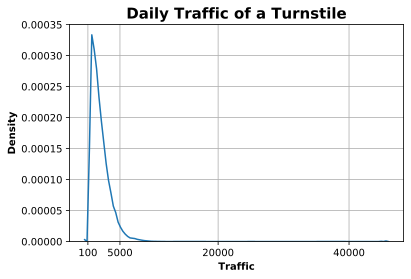

In [437]:
# Plotting chart to see trend in daily traffic of a turnstile device
chart_daily_turnstile = sns.kdeplot(df_turnstile_traffic_per_day['total_traffic']);
chart_daily_turnstile.set_title("Daily Traffic of a Turnstile", fontsize=15, weight='bold')
chart_daily_turnstile.set_xlabel("Traffic", weight='bold')
chart_daily_turnstile.set_ylabel("Density", weight='bold')
chart_daily_turnstile.grid(True)
chart_daily_turnstile.set(xticks=[100, 5000,20000,40000])
chart_daily_turnstile.get_legend().remove()

chart_daily_turnstile.get_figure().savefig("DailyTurnstilTraffic.png", bbox_inches = 'tight')


As we can see, most of our data (traffic per day per turnstile) falls between 100 - 5000. We've removed traffic 
above 50,000 since it seemed because of faulty data. There are still data points going well into 40,000 though. Not 
removing these since they could be accurate for the most trafficked stations. 

13995 (8.5% of total points) entry points where total traffic remained 0 throughout the day. This is most likely because the turnstile is broken or the turnstile really received no traffic at all. So getting no traffic data from these turnstiles.  

In [438]:
df_turnstile_traffic_per_day.loc[df_turnstile_traffic_per_day.total_traffic == 0]

,ca,unit,scp,station,date,entries_min,entries_max,exits_min,exits_max,traffic_entry,traffic_exit,total_traffic
15,A002,R051,02-00-00,59 ST,07/15/2018,6690828,6690828,2267744,2267744,0,0,0
49,A002,R051,02-00-01,59 ST,07/14/2018,5990336,5990336,1340775,1340775,0,0,0
85,A002,R051,02-03-00,59 ST,07/15/2018,1102694,1102694,4114927,4114927,0,0,0
99,A002,R051,02-03-00,59 ST,07/29/2018,1108043,1108043,4137412,4137412,0,0,0
120,A002,R051,02-03-01,59 ST,07/15/2018,761124,761124,1178617,1178617,0,0,0
155,A002,R051,02-03-02,59 ST,07/15/2018,5844000,5844000,7945146,7945146,0,0,0
169,A002,R051,02-03-02,59 ST,07/29/2018,5858270,5858270,7961331,7961331,0,0,0
190,A002,R051,02-03-03,59 ST,07/15/2018,5432988,5432988,6318627,6318627,0,0,0
204,A002,R051,02-03-03,59 ST,07/29/2018,5446148,5446148,6329755,6329755,0,0,0
225,A002,R051,02-03-04,59 ST,07/15/2018,6775353,6775353,3556944,3556944,0,0,0


## Data Preparation for Plotting / Data Analysis


In [439]:
# Calculating total station traffic for 35 days
df_total_station_traffic = df_turnstile_traffic_per_day.groupby(['station'])[['total_traffic']].sum()

In [440]:
# Expanding DataFrame created from grouping
df_total_station_traffic = df_total_station_traffic.reset_index()

In [441]:
# Sorting by traffic to get top 5 stations with most traffic
df_total_station_traffic_sorted = df_total_station_traffic.sort_values('total_traffic', ascending=False)

In [442]:
# Calculating station traffic per date
df_station_traffic_by_date = df_turnstile_traffic_per_day.groupby(['station', 'date'])[['total_traffic']].sum()

In [443]:
# Expanding DataFrame created from grouping
df_station_traffic_by_date = df_station_traffic_by_date.reset_index()

In [444]:
# Converting date to a relevant python data structure
df_station_traffic_by_date['date'] = pd.to_datetime(df_station_traffic_by_date['date'], format="%m/%d/%Y")

In [445]:
# Adding column for day of week for analysis by day of week
df_station_traffic_by_date['day'] = df_station_traffic_by_date['date'].dt.weekday_name

In [446]:
# Adding column for week of year for analysis by number
df_station_traffic_by_date['week'] = df_station_traffic_by_date['date'].dt.week - 26

In [447]:
# Top 5 stations with most activity
df_total_station_traffic_sorted.head()

,station,total_traffic
60,34 ST-PENN STA,8134858
232,GRD CNTRL-42 ST,7724126
58,34 ST-HERALD SQ,6078456
352,TIMES SQ-42 ST,5221325
14,14 ST-UNION SQ,5101187


In [448]:
# Storing top 5 stations for further analysis
top_1_station = "34 ST-PENN STA"
top_2_station = "GRD CNTRL-42 ST"
top_3_station = "34 ST-HERALD SQ"
top_4_station = "TIMES SQ-42 ST"
top_5_station = "14 ST-UNION SQ"

## Generating Plots for Data Analysis

### Plotting total traffic for whole time duration per station. This is to find most trafficked stations overall

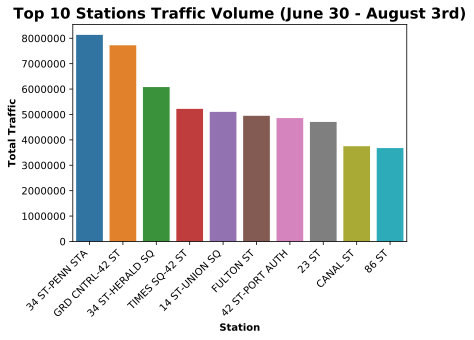

In [449]:
# Plotting total traffic for the 5 week period for top 10 stations

chart_total_traffic = sns.barplot(x = 'station',y='total_traffic',data=df_total_station_traffic_sorted.head(10))
chart_total_traffic.set_xticklabels(chart_total_traffic.get_xticklabels(), rotation=45, horizontalalignment='right')
chart_total_traffic.set_title("Top 10 Stations Traffic Volume (June 30 - August 3rd)", fontsize=15, weight='bold')
chart_total_traffic.set_xlabel("Station", weight='bold')
chart_total_traffic.set_ylabel("Total Traffic", weight='bold')

chart_total_traffic.get_figure().savefig("TotalTraffic_10.png", bbox_inches = 'tight')

Above chart shows top stations with most traffic we can target for the street teams.

### Plotting total traffic per day of week for our most trafficked station

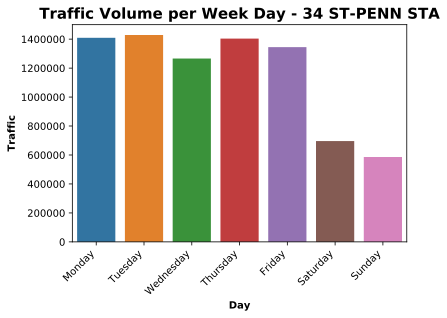

In [450]:
# Plotting traffic per different days of week for our most trafficked station

week_days_order = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

df_top1Station = df_station_traffic_by_date.loc[df_station_traffic_by_date.station == top_1_station]
df_top1Station_by_day = df_top1Station.groupby(['day'])[['total_traffic']].sum().reindex(week_days_order)
df_top1Station_by_day = df_top1Station_by_day.reset_index()

chart_traffic_day = sns.barplot(x = 'day',y='total_traffic',data=df_top1Station_by_day);
chart_traffic_day.set_xticklabels(chart_traffic_day.get_xticklabels(), rotation=45, horizontalalignment='right')
chart_traffic_day.set_title("Traffic Volume per Week Day - " + top_1_station, fontsize=15, weight='bold')
chart_traffic_day.set_xlabel("Day", weight='bold')
chart_traffic_day.set_ylabel("Traffic", weight='bold')

chart_traffic_day.get_figure().savefig("TrafficWeekdayBestStation.png", bbox_inches = 'tight')

Traffic on weekend is considerably lower than on weekdays

### Plotting total traffic per day of week for our 2nd most trafficked station

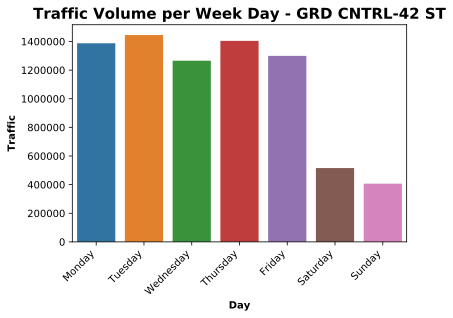

In [451]:
# Plotting traffic per different days of week for our 2nd most trafficked station
df_top2Station = df_station_traffic_by_date.loc[df_station_traffic_by_date.station == top_2_station]
df_top2Station_by_day = df_top2Station.groupby(['day'])[['total_traffic']].sum().reindex(week_days_order)
df_top2Station_by_day = df_top2Station_by_day.reset_index()

chart_traffic_day = sns.barplot(x = 'day',y='total_traffic',data=df_top2Station_by_day);
chart_traffic_day.set_xticklabels(chart_traffic_day.get_xticklabels(), rotation=45, horizontalalignment='right')
chart_traffic_day.set_title("Traffic Volume per Week Day - " + top_2_station, fontsize=15, weight='bold')
chart_traffic_day.set_xlabel("Day", weight='bold')
chart_traffic_day.set_ylabel("Traffic", weight='bold')

chart_traffic_day.get_figure().savefig("TrafficWeekday2ndBestStation.png", bbox_inches = 'tight')

Same trend seen here as well. Weekend traffic is considerably lower. 

### Plotting chart to get traffic per week for our 5 top stations for 4 weeks

In [452]:
# Filtering traffic by date for only our top 5 stations
df_station_traffic_by_date_top_5 = df_station_traffic_by_date.loc[(df_station_traffic_by_date.station == top_1_station) | \
                              (df_station_traffic_by_date.station == top_2_station) | \
                              (df_station_traffic_by_date.station == top_3_station) | \
                              (df_station_traffic_by_date.station == top_4_station) | \
                              (df_station_traffic_by_date.station == top_5_station)]

# Getting traffic by week for our top 5 stations
df_station_traffic_by_week_top_5 = df_station_traffic_by_date_top_5.groupby(['station', 'week'])[['total_traffic']].sum()

In [453]:
# Expanding DataFrame created from grouping
df_station_traffic_by_week_top_5 = df_station_traffic_by_week_top_5.reset_index()

In [454]:
# Removing Week 36 since data not complete for this week
df_station_traffic_by_week_top_5 = df_station_traffic_by_week_top_5.loc[df_station_traffic_by_week_top_5.week != 0]

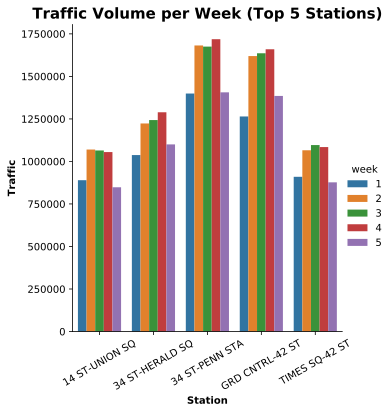

In [455]:
# Plotting chart to get weekly traffic for our 5 top stations for the whole 5 week time period
chart_traffic_week = sns.catplot(x='station', y='total_traffic', hue='week', data=df_station_traffic_by_week_top_5, kind='bar')
chart_traffic_week.set_xticklabels(rotation=30)

chart_traffic_week_axes = chart_traffic_week.axes.flatten()
chart_traffic_week_axes[0].set_title("Traffic Volume per Week (Top 5 Stations)", fontsize=15, weight='bold')
chart_traffic_week_axes[0].set_ylabel("Traffic", weight='bold')
chart_traffic_week_axes[0].set_xlabel("Station", weight='bold')

chart_traffic_week.savefig("TrafficPerWeek.png", bbox_inches = 'tight')

We can see increased activity on weeks 28, 29, 30 of 2018. The pattern holds across different stations. Otherwise, 
week wise traffic seems mostly consistent.

### Analysis for July 4th since it's a national holiday. Comparing data with July 11.

In [456]:
# Getting traffic on July 4th and July 11th for our top 5 most trafficked stations
df_station_traffic_July_4_11 = df_station_traffic_by_date_top_5.loc[(df_station_traffic_by_date.date == "2018/07/04") | \
                                                          (df_station_traffic_by_date.date == "2018/07/11")]

In [457]:
df_station_traffic_July_4_11_comparison = df_station_traffic_July_4_11.groupby(['station', 'date'])\
[['total_traffic']].sum()

In [458]:
df_station_traffic_July_4_11_comparison = df_station_traffic_July_4_11_comparison.reset_index()

In [459]:
df_station_traffic_July_4_11_comparison['date'] = df_station_traffic_July_4_11_comparison.date.dt.strftime('%Y-%m-%d')

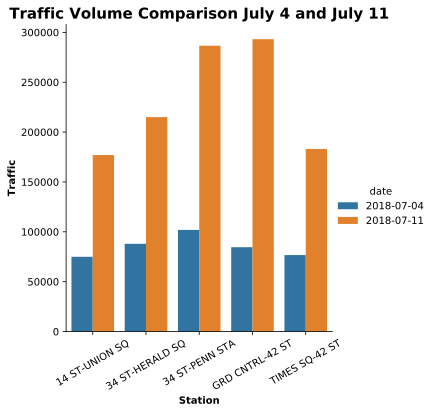

In [460]:
# Plotting chart to get weekly traffic for our 5 top stations for the whole 5 week time period
chart_traffic_july_4_11_comp = sns.catplot(x='station', y='total_traffic', 
                                           hue='date', data=df_station_traffic_July_4_11_comparison, kind='bar')
chart_traffic_july_4_11_comp.set_xticklabels(rotation=30)

chart_traffic_july_4_11_comp_axes = chart_traffic_july_4_11_comp.axes.flatten()
chart_traffic_july_4_11_comp_axes[0].set_title("Traffic Volume Comparison July 4 and July 11", fontsize=15, weight='bold')
chart_traffic_july_4_11_comp_axes[0].set_ylabel("Traffic", weight='bold')
chart_traffic_july_4_11_comp_axes[0].set_xlabel("Station", weight='bold')

chart_traffic_july_4_11_comp.savefig("TrafficComparison4_11_July.png", bbox_inches = 'tight')

As we can expect, there's greatly reduced traffic on July 4th compared to July 11th (both are Wednesdays) since July 4th
is a national holiday 

## Conclusion


WomenTechWomenYes should place their street teams at:
> 1. Station at 34 St-Penn
> 2. Station at Grd-Cntrl 42 Street

Teams should target Monday, Tuesday and Thursday to get access to most traffic. Teams should avoid weekends since 
traffic is considerably reduced. 

Teams should avoid public holidays such as July 4th since there is considerably reduced traffic at the stations.